In [ ]:
# Link to the code: https://haystack.deepset.ai/tutorials/19_text_to_image_search_pipeline_with_multimodal_retriever

In [11]:
# %pip install --upgrade pip
# %pip install farm-haystack[colab,inference]

In [12]:
import logging
logger = logging.getLogger(__name__)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(levelname)s %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)

In [24]:
import os
os.environ["HAYSTACK_TELEMETRY_ENABLED"] = "False"

In [14]:
from haystack.document_stores import InMemoryDocumentStore

# Here Here we initialize the DocumentStore to store 512 dim image embeddings
# obtained using OpenAI CLIP model
document_store = InMemoryDocumentStore(embedding_dim=512)


In [15]:
from haystack.utils import fetch_archive_from_http

doc_dir = "data/tutorial19"

fetch_archive_from_http(
    url="https://s3.eu-central-1.amazonaws.com/deepset.ai-farm-qa/datasets/documents/spirit-animals.zip",
    output_dir=doc_dir,
)


False

In [16]:
import os

from haystack import Document

images = [
    Document(content=f"./{doc_dir}/spirit-animals/{filename}", content_type="image")
    for filename in os.listdir(f"./{doc_dir}/spirit-animals/")
]

document_store.write_documents(images)


In [17]:
from haystack.nodes.retriever.multimodal import MultiModalRetriever

retriever_text_to_image = MultiModalRetriever(
    document_store=document_store,
    query_embedding_model="sentence-transformers/clip-ViT-B-32",
    query_type="text",
    document_embedding_models={"image": "sentence-transformers/clip-ViT-B-32"},
)

# Now let's turn our images into embeddings and store them in the DocumentStore.
document_store.update_embeddings(retriever=retriever_text_to_image)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Create embeddings:  50%|█████     | 1/2 [00:00<00:00,  1.48 Docs/s]
Documents Processed: 10000 docs [00:00, 13459.29 docs/s]


In [18]:
from haystack import Pipeline

pipeline = Pipeline()
pipeline.add_node(component=retriever_text_to_image, name="retriever_text_to_image", inputs=["Query"])


In [19]:
results = pipeline.run(query="Animal that lives in the water", params={"retriever_text_to_image": {"top_k": 3}})

# Sort the results based on the scores
results = sorted(results["documents"], key=lambda d: d.score, reverse=True)

for doc in results:
    print(doc.score, doc.content)



Create embeddings:   0%|          | 0/1 [00:00<?, ? Docs/s]
                                                           

0.5820417471398611 ./data/tutorial19/spirit-animals/dolphin-spirit-animal.jpg
0.5787264692951111 ./data/tutorial19/spirit-animals/turtle-spirit-animal.jpg
0.5726587696015375 ./data/tutorial19/spirit-animals/polar-bear-spirit-animal.jpg


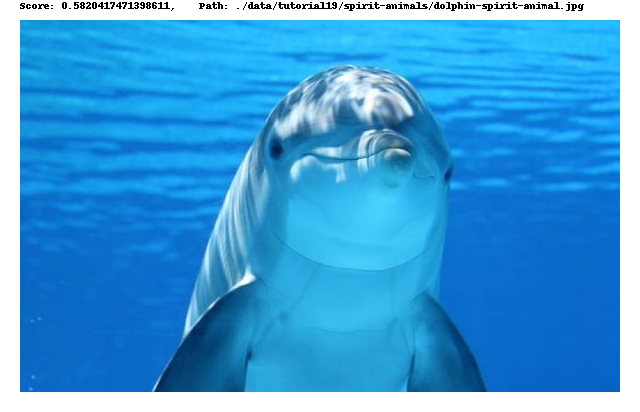

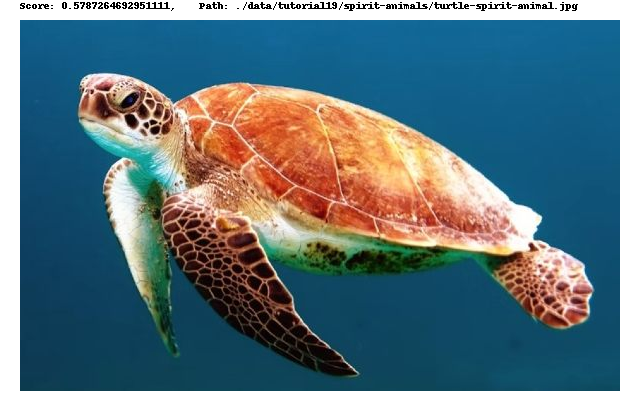

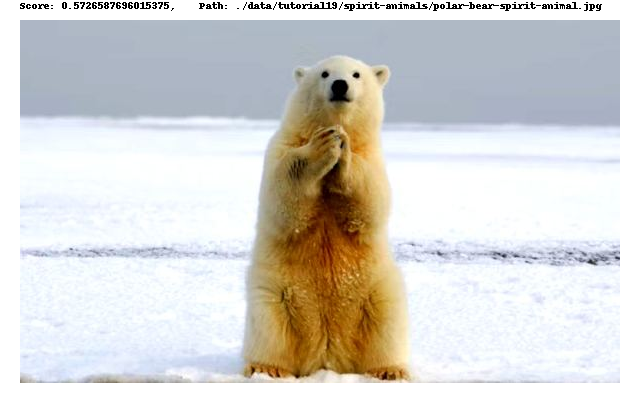

In [20]:
from io import BytesIO
from PIL import Image, ImageDraw, ImageOps
from IPython.display import display, Image as IPImage


def display_img_array(ima, score):
    im = Image.open(ima)
    img_with_border = ImageOps.expand(im, border=20, fill="white")

    # Add Text to an image
    img = ImageDraw.Draw(img_with_border)
    img.text((20, 0), f"Score: {score},    Path: {ima}", fill=(0, 0, 0))

    bio = BytesIO()
    img_with_border.save(bio, format="png")
    display(IPImage(bio.getvalue(), format="png"))


images_array = [doc.content for doc in results]
scores = [doc.score for doc in results]
for ima, score in zip(images_array, scores):
    display_img_array(ima, score)
